# Quick example of WL Classification
## using Valen's warm up and our virtual label model
This example tries to show the usage of the classes and methods
proposed here to show classification with weakly labeled datasets.

We will use the model proposed by Valen and their warm up prior to 20 epochs
with our method (We will use the

In [1]:
# Importing general libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Importing specific classes and functions
from utils.weakener import Weakener

#Importing drawing tools
import matplotlib.pyplot as plt

#importing dataloaders
from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from models.model import MLP,mlp_valen
from utils.trainig_testing import train_model,evaluate_model,train_and_evaluate
from utils.losses import EMLoss, CELoss

from utils.warm_up import warm_up_benchmark

In [2]:
# DS stores the dataset and its related attributes
DS = Torch_Dataset('mnist')
train_x, train_y, test_x, test_y = DS.get_data()
# WL stores pocesses relative to the Weakening process
WL = Weakener(DS.num_classes)


In [3]:
# Generation of the mixing matrix according to the model
#  we've chosen.
WL.generate_M(model_class='pll')

In [4]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
z, w = WL.generate_weak(train_y)

z is the numerical encodig of the weak label while w is a one-hot
representation of that variable. z also encodes the row of the M matrix
for that given weak label.

Let's consider the example of partial label learning for the iris dataset.
labels are encoded as ```{0: '011', 1: '101', 2: '110', 3: '111'}```
so having an isntance with `z=3` means `w=[1,1,1]`, i.e., the weak label contains every label.

In [5]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
WL.virtual_matrix()
#And we generate the virtual labels
WL.virtual_labels(train_y)


#we make a new dataloader because valen takes the weak label instead of the
# virtual label.
indices = torch.arange(0,len(train_x))
valen_train_data = TensorDataset(train_x, w ,train_y, indices)
valen_train_loader = DataLoader(valen_train_data, batch_size=64, shuffle=True)


WL.virtual_labels(train_y)
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

In [6]:
mlp = mlp_valen(DS.num_features,DS.num_features,DS.num_classes)

In [7]:
mlp = warm_up_benchmark(mlp,valen_train_loader,testloader)

Begin warm-up, warm up epoch 10
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
After warm up, test acc: 0.0000
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
After warm up, test acc: 0.0005
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]

C:\Users\danibacaicoa\PycharmProjects\Learning_from_weak_labels\utils\losses.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logp = self.logsoftmax(v)


In [8]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

mlp

mlp_valen(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=784, out_features=10, bias=True)
)

In [9]:
# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=10)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 1/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 2/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 3/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 4/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 5/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 6/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 7/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 8/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 9/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Epoch 10/10: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980
Train Loss: nan
Train Accuracy: tensor(0.0987, dtype=torch.float64)
Test Accuracy: tensor(0.0980, dtype=torch.float64)


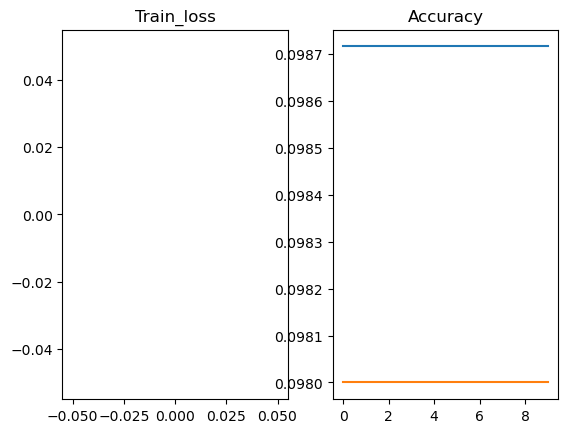

In [10]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()

In [11]:
#We need to include this Weak Labels into the dataset,
# we need to include w to mantain the coherence. z will only be used
# in the loss for the EM
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

print(len(testloader.dataset))
print(len(trainloader.dataset))

10000
60000


Now we have a trainloader containing (X,v,y) and a testloader containig (X,y)
so we can just establish our model and train it.

In [12]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

train_losses,train_accs=train_model(mlp,trainloader,optimizer,
                                    loss_fn,num_epochs=10)

# Print the final training loss and accuracy
print('Final Training Loss: {:.4f}'.format(train_losses[-1]))
print('Final Training Accuracy: {:.4f}'.format(train_accs[-1]))

Epoch 1/10 - Loss: 1.4161 - Accuracy: 0.5313
Epoch 2/10 - Loss: 1.0031 - Accuracy: 0.6483
Epoch 3/10 - Loss: 0.8992 - Accuracy: 0.6744
Epoch 4/10 - Loss: 0.8139 - Accuracy: 0.6825
Epoch 5/10 - Loss: 0.7173 - Accuracy: 0.6905
Epoch 6/10 - Loss: 0.6819 - Accuracy: 0.6959
Epoch 7/10 - Loss: 0.5980 - Accuracy: 0.6992
Epoch 8/10 - Loss: 0.5720 - Accuracy: 0.7035
Epoch 9/10 - Loss: 0.5042 - Accuracy: 0.6977
Epoch 10/10 - Loss: 0.3594 - Accuracy: 0.6998
Final Training Loss: 0.3594
Final Training Accuracy: 0.6998


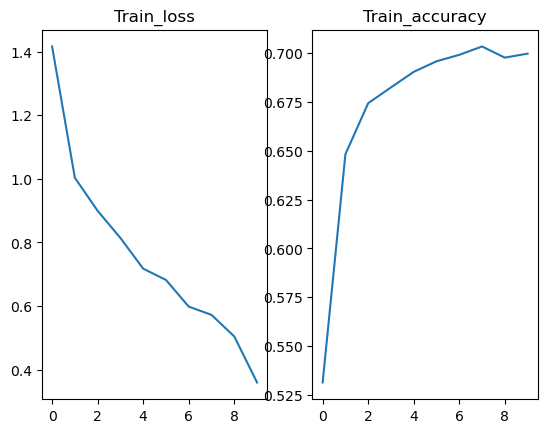

In [13]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(train_losses)
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(train_accs)
axis[1].set_title("Train_accuracy")
plt.show()

In [14]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=10)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 1/10: Train Loss: 1.4023, Train Acc: 0.5410, Test Acc: 0.8506
Epoch 2/10: Train Loss: 0.9963, Train Acc: 0.6529, Test Acc: 0.8824
Epoch 3/10: Train Loss: 0.8830, Train Acc: 0.6741, Test Acc: 0.8865
Epoch 4/10: Train Loss: 0.7502, Train Acc: 0.6828, Test Acc: 0.8891
Epoch 5/10: Train Loss: 0.6973, Train Acc: 0.6851, Test Acc: 0.8902
Epoch 6/10: Train Loss: 0.5961, Train Acc: 0.6891, Test Acc: 0.8908
Epoch 7/10: Train Loss: 0.5397, Train Acc: 0.6891, Test Acc: 0.8874
Epoch 8/10: Train Loss: 0.4785, Train Acc: 0.6892, Test Acc: 0.8908
Epoch 9/10: Train Loss: 0.4425, Train Acc: 0.6855, Test Acc: 0.8846
Epoch 10/10: Train Loss: 0.3441, Train Acc: 0.6784, Test Acc: 0.8825
Train Loss: 0.34407501089234166
Train Accuracy: tensor(0.6784, dtype=torch.float64)
Test Accuracy: tensor(0.8825, dtype=torch.float64)


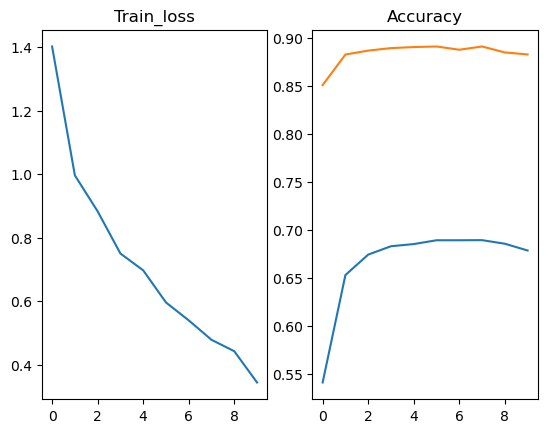

In [15]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()